## Voting Classifier
Majority vote classifier is also called as hard voting classifier  

**Law of Large Numbers**  
Suppose a biased coin has probability of getting heads is 51% and tails 49%, if we toss it for 1000 times, we'll have probability of obtaining majority heads = 75% (510 H, 490 T), if we toss it for 10,000 times, we'll have probability of obtaining majority heads climbed to  = 97%.  
That means as we keep tossing the coing, the ratio of heads gets closer and closer to the probability of heads (51%).  
<br>
Similarly if we build an ensemble containing 1,000 classifiers that are individually correct 51% of the time (barely better than random guessing), we can hope up for 75% accuracy.  
However this is only true if all if all classifiers are perfectly independant, making uncorrelated errors, but here they are trained on the same data , so they will make similar type of errors hence reducing accuracy again. One way can be to get diverse classifiers using different learning algorithms so they will make very different type of errors, improving ensemble accuracy again

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

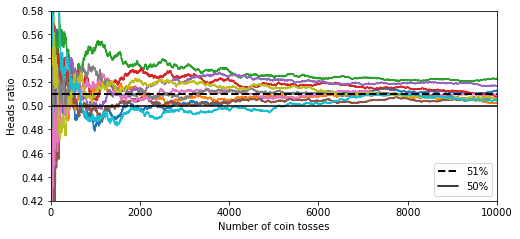

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1,1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0,10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0,10000, 0.42, 0.58])
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise = 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Hard voting
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting="hard"
)

In [5]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__ , accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [7]:
#Soft voting
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True , random_state=42)  #Had to enable probability

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting="soft"
)

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__ , accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


If all classifiers have predict_proba method, then we can also predict the class with highest probabilities averaged over all the individual classifiers using **voting="soft"**. It often achievves higher performance than hard voting because it give more weight to highly confidant class.
<br>

## Bagging and Pasting
Previous approach was to use different training algorithms. Now the approach is to use same training algorithm for every predictor but to train them on different subsets of the training set.  
**Bagging:** When sampling is performed with replacement, this method is called *Bagging (Bootstrap aggregating - Resampling with replacement)*  
**Pasting:** When sampling is performed without replacement, it is called *"Pasting"*.  

So both Bagging and Pasting allows training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.  

Each indivual predictor has higher bias than if it were trained on the original training set, but aggregation of them reduces both bias and variance.  
Generally the net result is, ensemble has similar bias but lower variance than a single predictor trained on the original training set.  

Predictors can all be trained in parallel or even different servers. Also prediction can be made in parallel.  

> BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate probabilities

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Training 500 decision trees with 100 resampled from training set with replacement on all CPU cores  (n_jobs = -1)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1,x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18)

### Comparing decision boundary of Single Decision Tree vs Decision Tree with Bagging

In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


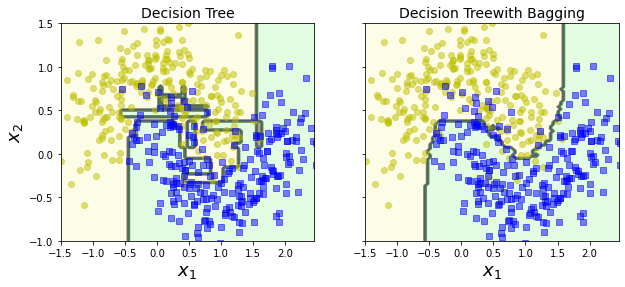

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X,y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X,y)
plt.title("Decision Treewith Bagging", fontsize=14)
plt.ylabel("")
plt.show()

Ensemble here has comparable bias but smaller variance (it makes roughly the same number of errors on training set but the decision boundry is less irregular).  

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up having slightly higher bias than pasting, but this also means that predictor ends up being less correlated so ensemble's variance is reduced. So mostly bagging results in better model.  
<br>
### Out-Of-Bag evaluation  
With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.  
So the training instances that were not sampled for given predictor are called as ***out-of-bag (oob)*** instances. Note that they are not sample unsampled instances for all predictors.  

Since a predictor never sees oob instances during training, it can be evauluated on these instances without the need for saparate validation set.

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    bootstrap=True, oob_score=True, n_estimators = 500, random_state=40
)

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.8986666666666666

According to this oob evaluation, above BaggingClassifer is likely to achieve about 89.9% accuracy on the test set. Let's verify it

In [14]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Also sampling features results in more predictor diversity traing a bit more bias for lower variance.  

**Random Patches Method:** Sampling both training instances and features.  
**Random Subspaces Method:** Keeping all training instances and Sampling features.  

## Random Forest  
Random Forest is an ensemble of Decision Trees generally trained via bagging method (or sometimes pasting method) typically with max_samples set to size of training set.  
It is also more optimized for Decision Trees instead of using BaggingClassifer.  

- It introduces extra randomness when growing trees instead of searching for the very best feature when splitting a node, it searches for best feature among a random subset of features resulting in greater tree diversity which again trades in more bias for lower variance and a better generalized result.
- It is possible to make trees more random by using random thresholds for each features rather than searching for the best possible thresholds like regular DTs. A forest of such extremely random trees is called as ***Extremely Randomized Trees (Extra-Trees)*** ensemble. It makes Extra-Trees much faster to train than regular Random Forest since finding best possible threshold for each feature at each node is more time consuming. Sci-Kitlearn API is *ExtraTreesClassifer / ExtraTreesRegressor*


In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [16]:
#Equivalent Bagging implementation
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42 
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  #checking for predictions similarity

1.0

### Feature Importance
Scikit-Learn measures feature's importance by looking at how much the tree nodes that use the feature reduce impurity on average (across all trees in the forest), more precisely weighted average with number of training samples of a node as weight of the node.  

For ex. on below iris dataset, it seems most important features are the petal length 44.1% and width 42.3% while sepal length and widths are rather unimportant in comparison (11.2% and 2.3% respectively)

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [19]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [20]:
#RF on MNIST
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [21]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [22]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

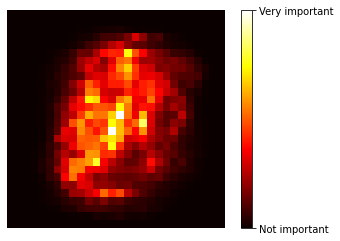

In [23]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## Boosting
Also called as Hypothesis Boosting, refers to any Ensemble method that can combine several week learners into a strong learner.  
Idea is to train predictors sequentially, each trying to correct it's predecessor.  
<br>
### AdaBoost
For new predictor to correct it's predecessor if we pay a bit more attension to the training instances that underfitted the predecessor. This results in new predictiors focusing more and more on the hard cases.  
Ex. to build AdaBoost classifier, a first base classifier is trained and used to make predictions on training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using updated weights and again it makes predictions on training set, weights are updated and so on.  
> **Multiclass Version of AdaBoost:**  
> ***SAMME*** (Stagewise Additive Modeling using Multiclass Exponential loss function)  
> ***SAMME.R***- If predictor outputs class probabilities (using predict_proba) then Scikit-Learn can use a variant of SAMME called ***SAMME.R*** (R -real), which relies on class probabilites rather than predictions and generally performs better.  

If your AdaBoost is overfitting training set, you can try reducing the number of estimators or more strongly regularizing the base estimator

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

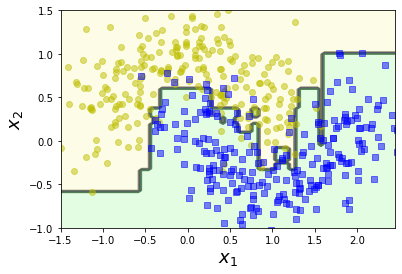

In [25]:
plot_decision_boundary(ada_clf, X, y)

## Gradient Boosting  
Just like Ada Boost, Gradient Boosting works by sequentially adding predictors to ensemble each one correcting its predecessor. However instead of twicking the instance weights at every iteration like AdaBoost does, it tries to fit the new predictor to the ***residual errors*** made by previous predictor.  

### Gradient Boosted Regression Trees

In [26]:
#Create simple quadratic dataset

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [27]:
#Training decision tree regressor

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [28]:
y2 = y - tree_reg1.predict(X)

#Training on previous predictor's residual error
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [29]:
y3 = y2 - tree_reg2.predict(X)

#Training on previous predictor's residual error
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
X_new = np.array([[0.8]])

Now we have ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all tree.

In [31]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [32]:
#Plotting 
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

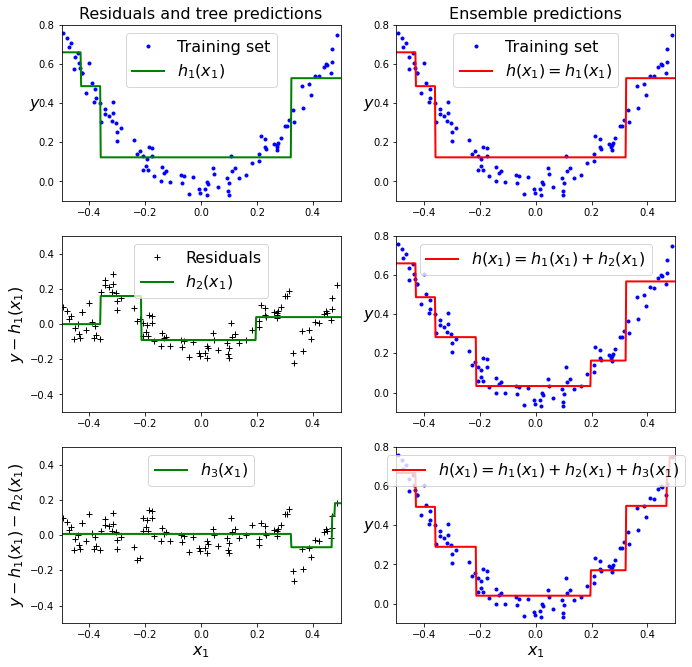

In [33]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [34]:
#Following code creates same ensemble as previous ones
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- **learning_rate**: Scales contribution of each tree. If we set it too low ex 0.1, we'll need more trees in the ensemble to fit the training set, but predictions will usually generalize better. This regularization technique is called ***shrinkage***  

In [35]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

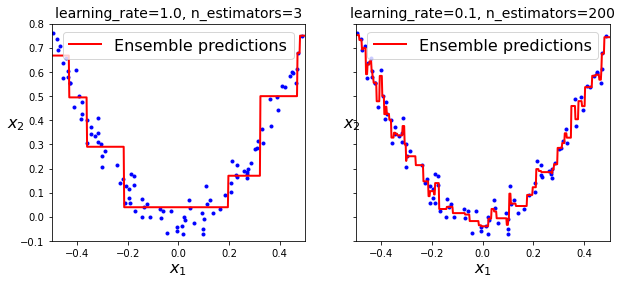

In [36]:
fig , axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X,y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X,y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16, rotation=0)
plt.show()

### Early Stopping GBRT
#### Train large number of trees first then looking back to find optimal number
In order to find optimal number of trees, you can use early stopping. Use ***staged_predict()*** method. It returns iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees etc.).  

Following code trains GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees and fianlly trains another GBRT ensemble using optimal number of trees.

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val, y_pred) 
          for y_pred in gbrt.staged_predict(X_val)]

best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=80, random_state=42)

In [38]:
min_error = np.min(errors)

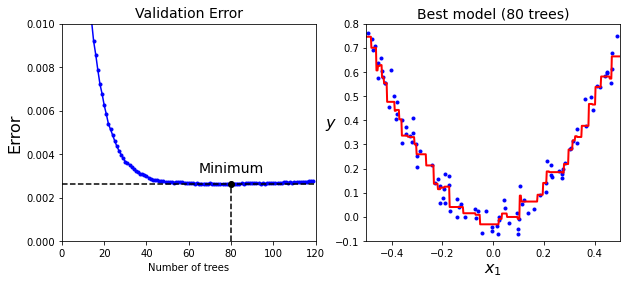

In [39]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0,120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0 , 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation Error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y ,axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

#### Actually stopping Training early
- ***warm_start = True***- Makes scikit-learn keep existing trees when the fit() method is called, allowing incremental training.  

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [40]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [41]:
print(gbrt.n_estimators)
print("Minimum validation MSE:",min_val_error)

59
Minimum validation MSE: 0.0026930464329994377


#### Stochastic Gradient Boosting
- ***subsample***: This hyerpparameter specifies fraction of training instances to be used for each tree. Ex subsample = 0.25 means each tree is trained on 25% of the training instances selected randomly.
- This trades a higher bias for lower variance and speeds up training considerably.
- Controll cost function using loss parameter

### Using XGBoost
- It is library for optimized implementation of Gradient Boosting which stands for *Extreme Gradient Boosting*
- It aims at being extremely fast, scalable, portable.

In [42]:
#!pip install xgboost
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

0.0032701197793426123

In [44]:
#Automatic early stopping
xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)], early_stopping_rounds=2
           )
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

[0]	validation_0-rmse:0.21512
[1]	validation_0-rmse:0.16304
[2]	validation_0-rmse:0.12217
[3]	validation_0-rmse:0.09683
[4]	validation_0-rmse:0.08110
[5]	validation_0-rmse:0.06992
[6]	validation_0-rmse:0.06311
[7]	validation_0-rmse:0.05919
[8]	validation_0-rmse:0.05735
[9]	validation_0-rmse:0.05613
[10]	validation_0-rmse:0.05612
[11]	validation_0-rmse:0.05593
[12]	validation_0-rmse:0.05599
[13]	validation_0-rmse:0.05610


0.003127625770568247

#### Speed Comparison XGBoost vs GradientBoosting 

In [45]:
%%timeit
xgboost.XGBRegressor().fit(X_train, y_train)

60.5 ms ± 719 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%%timeit
GradientBoostingRegressor().fit(X_train, y_train)

16.9 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Stacking
- Instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don't we train a model to perform this aggregation.  

Predict using ensemble of predictors --> Then pass it to the **Blender/Meta Learner** to make final predictions.  

## Exercise Solutions
Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).

In [47]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM.

In [48]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [49]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [50]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the SVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [52]:
#Instead of SVC, training LinearSVC
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
svm_clf.fit(X_train, y_train)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

In [53]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.961]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [54]:
from sklearn.ensemble import VotingClassifier

named_estimators =[
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf",mlp_clf)
]

In [55]:
voting_clf scoreotingClassifier(named_estimators)

In [56]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [57]:
voting_clf.score(X_val, y_val)

0.971

In [58]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.961]

Let's remove SVM to see if performance improves. 

In [59]:
voting_clf.set_params(svm_clf = None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [60]:
#Updated list of estimators
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [61]:
#However it did not update list of trained estimators
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [62]:
#So we can either fit the VotingClassifier again or just remove SVM from the list of trained estimators
del voting_clf.estimators_[2]

In [63]:
#Let's evaluate VotingClassifier again
voting_clf.score(X_val, y_val)

0.9733

A bit better! SVM was hurting performance. Now let's try using soft voting classifier. We don't actually need to retrain the classifier, we can just set voting to "soft"

In [64]:
voting_clf.voting = "soft"

In [65]:
voting_clf.score(X_val, y_val)

0.9681

Now hard voting wins in this case!  

Let's try this on test set and compare it with individual classifiers.

In [66]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.971

In [68]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9612]

The voting classifier only very slightly reduced the error rate of the best model in this case.  
<br>
**Stacking Ensemble**  
Exercise: Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [69]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype = np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [70]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [71]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [72]:
rnd_forest_blender.oob_score_

0.9685

If needed, we can fine tune current blender or try other types of blenders (e.g. MLPClassifier) and the select the best one using cross validation.  

Now let's evaluate the ensemble on the test set.  
For each image in the test set, make predictions with all of our classifiers, then feed the predictions to the blender to get ensemble's predictions. 

In [73]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype = np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [74]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [75]:
accuracy_score(y_test, y_pred)

0.9685

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.